In [1]:
import torch as t
import matplotlib.pyplot as plt

In [3]:
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [4]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [129]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	20,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  20,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

In [130]:
exp_path = os.path.join(dir_path,'Plotting','tmp_UE0s')
params_dict.update({"exp_path":exp_path})

In [131]:
class QTrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.QTrotter, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        # self.alphas = alphas
        # self.control = control
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
QT = QTrotter(params_dict)

I added a factor half to the cosines


In [132]:
def phi_potential(phiXX,phiYY,alpha=1):
    return -QT.EJ*(t.cos(phiXX) + t.cos(phiYY) + alpha*t.cos(phiXX - phiYY - QT.phi_ext.real))

def get_eigvecs(alpha,u):
    H = QT.get_H(alphas=t.tensor([alpha]),control=t.tensor([u])).squeeze()
    eigvals, eigvecs = t.linalg.eigh(H)
    return eigvecs.T.view(eigvals.shape[0],QT.NHilbert,QT.NHilbert)

def q_to_phi(qstate):
    return t.fft.fftshift(t.fft.ifft2(t.fft.ifftshift(qstate)))

In [142]:
q = t.arange(-QT.q_max,QT.q_max+1,1)
XX, YY = t.meshgrid(q,q)

phi = t.linspace(-t.pi,t.pi,q.shape[0])
# phiXX, phiYY = t.meshgrid(t.fft.fftshift(t.fft.fftfreq(21,1)*t.pi),t.fft.fftshift(t.fft.fftfreq(21,1)*t.pi))
phiXX, phiYY = t.meshgrid(phi,phi)

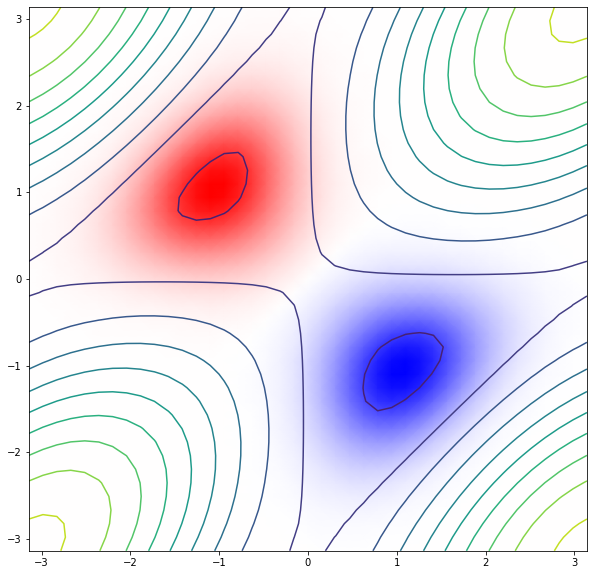

In [165]:
eigvecs = get_eigvecs(1,0)
plt.figure(figsize=(10,10))
plt.contour(phiXX,phiYY,phi_potential(phiXX,phiYY,1),levels=10)
plt.pcolormesh(phiXX,phiYY,q_to_phi(eigvecs[0]).abs()-q_to_phi(eigvecs[1]).abs(),shading='gouraud',cmap="bwr")

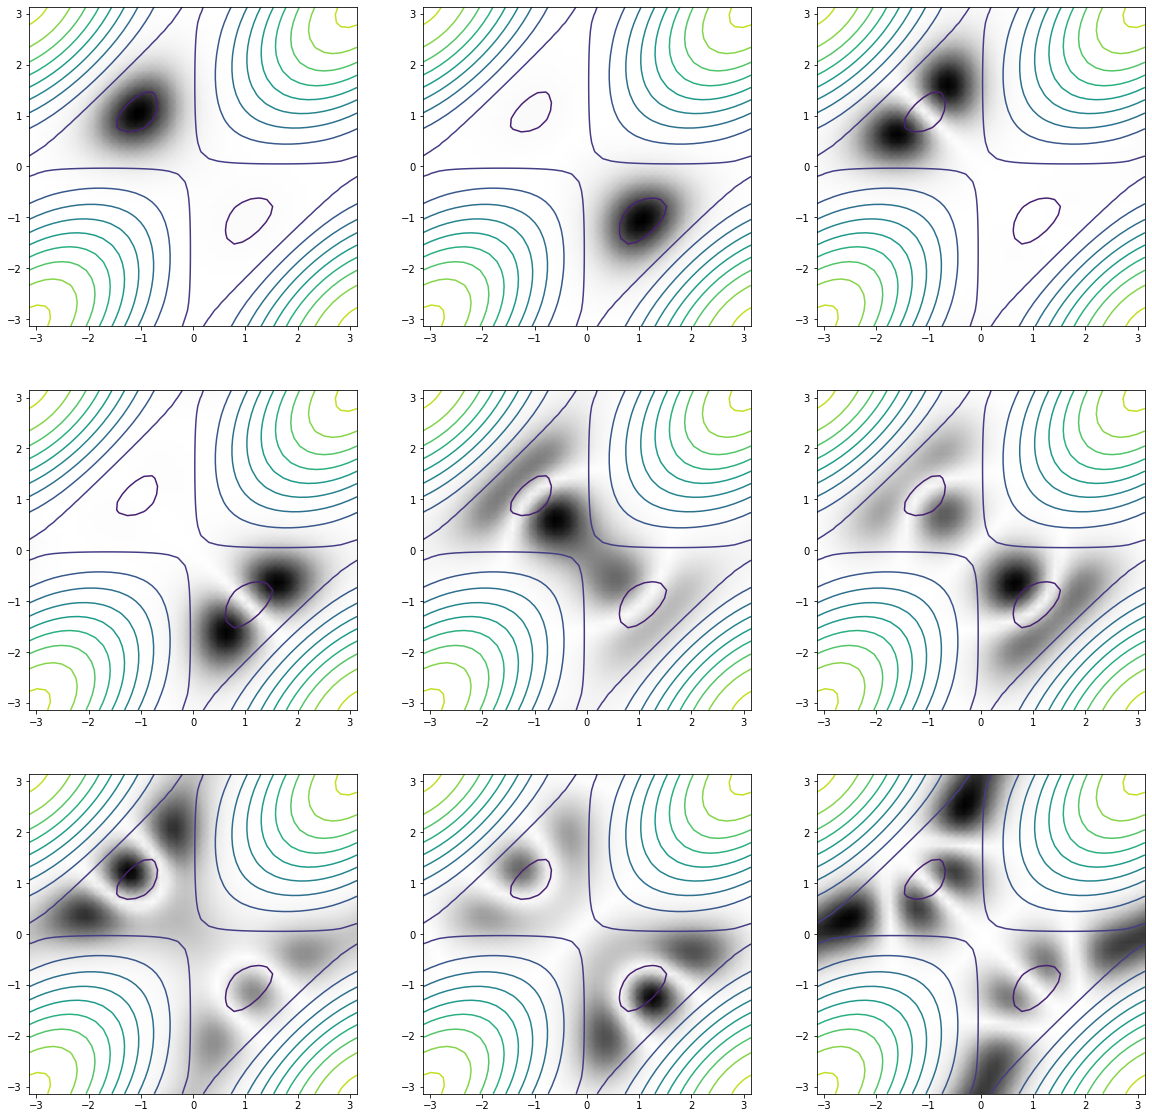

In [170]:
fig, ax = plt.subplots(figsize=(20,20),ncols=3,nrows=3)
ax = ax.flatten()

alpha = 1
eigvecs = get_eigvecs(alpha,0)

for i in range(ax.shape[0]):
    ax[i].contour(phiXX,phiYY,phi_potential(phiXX,phiYY,alpha),levels=10)
    ax[i].pcolormesh(phiXX,phiYY,q_to_phi(eigvecs[i]).abs(),shading='gouraud',cmap="Greys")